# CS 545 Project: Seismic Event Classification with CNN and Transformer 
Sam Burton, Sofia Catalan

## Helper Functions

In [1]:
import torch 
from torch import nn
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import d2l

### Data Exploration Functions

#### Class Distribution

In [2]:
def display_class_distribution(class_names, counts):
    colors = plt.cm.magma(np.linspace(0, 1, len(class_names)))
    
    plt.figure(figsize=(10, 5))
    plt.bar(class_names.astype(int), counts, color=colors)
    plt.title("Distribution of Seismic Waves")
    plt.xlabel("Seismic Wave Types")
    plt.xticks(class_names.astype(int))
    plt.ylabel("Number of Samples")
    plt.show()

#### Plotting Random Waveforms

In [3]:
import random

In [4]:
def get_random_waveforms(data, size=3):
    waveform_dict = {}
    class_names = data.get_class_names()
    for label in class_names:
        label_waveforms = data.X[data.y == label] # assuming data class has X, y as member variables
        random_indices = np.random.choice(len(label_waveforms), size=size, replace=False)
        
        waveform_dict[label] = label_waveforms[random_indices]
    return waveform_dict

In [5]:
def plot_waveforms(data, waveform_dict):
    nrows=len(data.get_class_names()) # total number of classes
    ncols=len(waveform_dict[data.get_class_names()[0]]) # total number of waveforms per class
    
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, 
                           figsize = (ncols * 3, nrows * 3))
    for i, label in enumerate(waveform_dict):
        for j, waveform in enumerate(waveform_dict[label]):
            ax[i, j].plot(waveform)
            ax[i, j].set_xlabel("Time")
            ax[i, j].set_ylabel("Amplitude")
        ax[i, ncols // 2].set_title(f'Class {label.astype(int)}', fontsize=20)
    plt.tight_layout()
    plt.show()

### Evaluation Metrics

In [6]:
from sklearn.metrics import classification_report, balanced_accuracy_score, accuracy_score, confusion_matrix

In [7]:
def evaluation_metrics(model, data):
    actual = []
    predicted = []
    
    model.eval()
    for batch_X, batch_y in data.get_dataloader('train'):
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        with torch.no_grad():
            preds = model(batch_X)

            y_actual = batch_y.cpu().tolist()
            y_pred = torch.argmax(preds, dim=1).cpu().tolist()

            actual.extend(y_actual)
            predicted.extend(y_pred)
    accuracy = balanced_accuracy_score(actual, predicted) # determine if to use balanced_accuracy or just accuracy
    report = classification_report(actual, predicted, 
                                   target_names=data.get_class_names(), zero_division=0) # make a get_class_names function to get class names
    confusion_matrix = confusion_matrix(actual, predicted)

    results = {
        'accuracy': accuracy,
        'report': report,
        'confusion matrix': confusion_matrix
    }
    return results

In [8]:
from sklearn.metrics import ConfusionMatrixDisplay

In [9]:
def display_confusion_matrix(confusion_matrix, class_names):
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(actual, predicted), display_labels=class_names)
    fig, ax = plt.subplots(figsize=(15, 15))
    disp.plot(ax=ax, include_values=True, cmap=plt.cm.Blues)
    ax.set_xticklabels(class_names, rotation=90)

## Data Class

In [10]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

In [11]:
class SeismicData(d2l.DataModule):
    def __init__(self, X, y, test_size=0.2, val_size=0.2, batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        self.X = X
        self.y = y

        self.test_size = test_size
        self.val_size = val_size
        self.batch_size = batch_size

        self.train, self.val, self.test = self.get_data_splits()
        

    def get_data_splits(self):
        X_trainval, X_test, y_trainval, y_test = train_test_split(self.X, self.y, test_size=self.test_size, stratify=self.y, shuffle=True, random_state=1)
        
        val_size = self.val_size / (1 - self.test_size) # adjust validation set size
        X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=val_size, stratify=y_trainval, shuffle=True, random_state=1)

        # Convert to torch tensors
        X_train = torch.tensor(X_train, dtype=torch.float32)
        X_val = torch.tensor(X_val, dtype=torch.float32)
        X_test = torch.tensor(X_test, dtype=torch.float32)

        y_train = torch.tensor(y_train, dtype=torch.int64)
        y_val = torch.tensor(y_val, dtype=torch.int64)
        y_test = torch.tensor(y_test, dtype=torch.int64)

        # Create Tensor Datasets
        train_ds = TensorDataset(X_train, y_train)
        val_ds = TensorDataset(X_val, y_val)
        test_ds = TensorDataset(X_test, y_test)

        return train_ds, val_ds, test_ds

    def get_dataloader(self, flag):
        shuffle = False
        if flag == 'train':
            data = self.train
            shuffle=True
        elif flag == 'val':
            data = self.val
        elif flag == 'test':
            data = self.test
        else:
            raise Exception("flag must be 'train', 'val', or 'test'")
        
        return DataLoader(data, self.batch_size, shuffle=shuffle, num_workers=self.num_workers)

    def get_class_names(self):
        class_names = np.unique(self.y)
        return class_names

## Fetching Data

In [12]:
import glob

In [13]:
csv_files_path = glob.glob("data/*.csv")

df_list = []
count_samples = 0
for filename in csv_files_path:
    print(filename, len(pd.read_csv(filename, header=None)))
    count_samples += len(pd.read_csv(filename, header=None))
    df_list.append(pd.read_csv(filename, header=None))

dataset_df = pd.concat(df_list, axis=0)
print("Total number of samples:", count_samples)

data\Template_1.csv 263
data\Template_10.csv 25973
data\Template_11.csv 272
data\Template_12.csv 272
data\Template_13.csv 272
data\Template_14.csv 272
data\Template_15.csv 272
data\Template_16.csv 272
data\Template_17.csv 269
data\Template_2.csv 263
data\Template_3.csv 203
data\Template_4.csv 236
data\Template_5.csv 245
data\Template_6.csv 272
data\Template_7.csv 269
data\Template_8.csv 272
data\Template_9.csv 269
Total number of samples: 30166


In [14]:
dataset_np = dataset_df.to_numpy()
dataset_np.shape, dataset_df.shape

((30166, 4002), (30166, 4002))

In [15]:
X, y = dataset_np[:, 1:], dataset_np[:, 0]
X.shape, y.shape

((30166, 4001), (30166,))

In [16]:
len(np.unique(y))

17

In [17]:
dataset = SeismicData(X, y, test_size=0.2, val_size=0.2, batch_size=32)

In [18]:
len(dataset.train), len(dataset.val), len(dataset.test)

(18099, 6033, 6034)

In [19]:
len(dataset.train) + len(dataset.val) + len(dataset.test)

30166

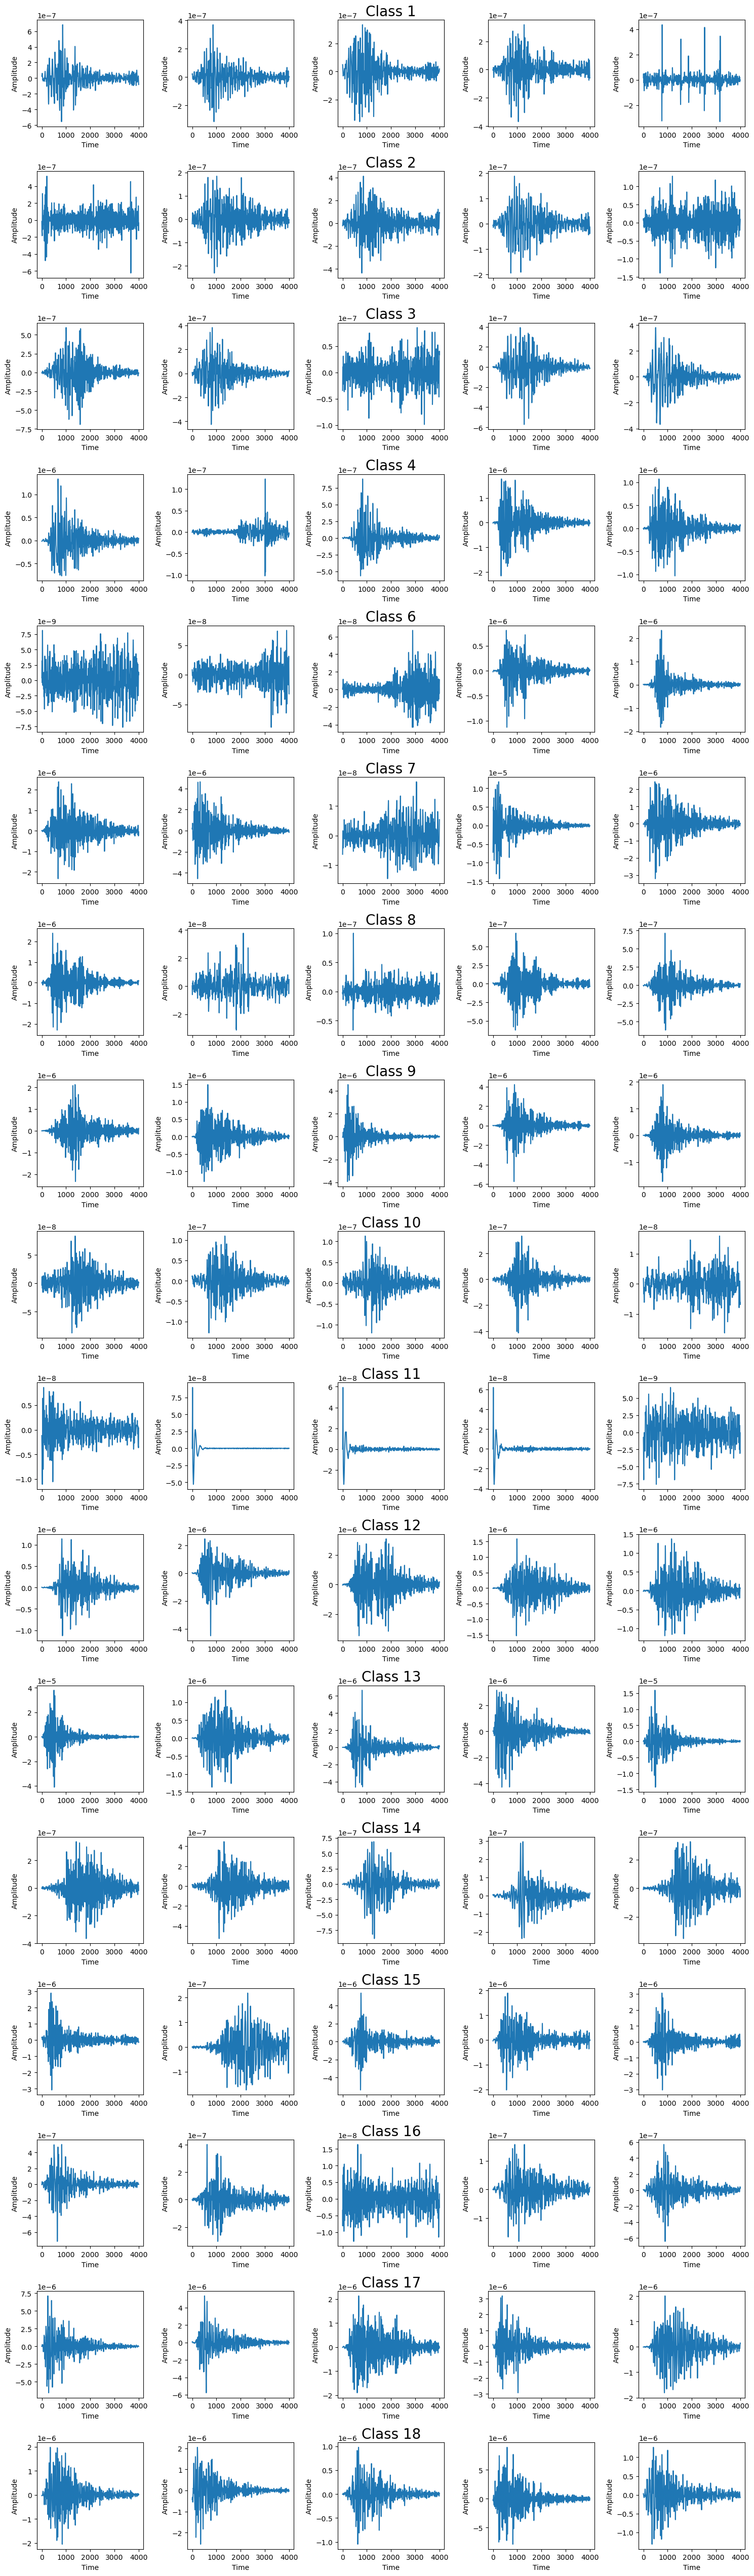

In [20]:
waveform_dict = get_random_waveforms(dataset, size=5)
plot_waveforms(dataset, waveform_dict)

In [21]:
class_names, counts = np.unique(dataset.y, return_counts=True)
class_names, counts

(array([ 1.,  2.,  3.,  4.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
        15., 16., 17., 18.]),
 array([  263,   263,   203,   236,   245,   272,   269,   272,   269,
        25973,   272,   272,   272,   272,   272,   272,   269]))

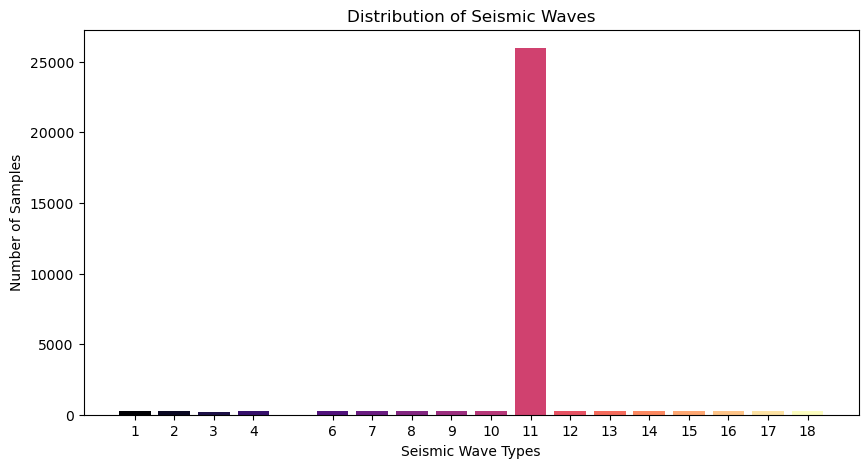

In [22]:
display_class_distribution(class_names, counts)